<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#fasttext-models" data-toc-modified-id="fasttext-models-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>fasttext models</a></span></li><li><span><a href="#networks" data-toc-modified-id="networks-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>networks</a></span></li></ul></div>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
import pickle

from gensim.models.fasttext import FastText
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, Input, Concatenate, Reshape, LSTM, GRU
from keras.optimizers import Adam
from keras.preprocessing.text import text_to_word_sequence

from sklearn.metrics import roc_curve, roc_auc_score

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import hyperopt.pyll.stochastic

import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


# fasttext models

In [3]:
df_chats_raw = pd.read_csv('../data/clean_text.csv')

In [4]:
class SentenceIterator(object):
    texts = None

    def __init__(self, texts):
        self.texts = texts

    def __iter__(self):
        for text in self.texts:
            yield text_to_word_sequence(text, lower=False)

In [5]:
def build_fasttext(size=100):
    path = '../data/fasttext_chats_%d.pkl' % size
    if os.path.exists(path):
        m = FastText.load(path)
    else:
        m = FastText(SentenceIterator(df_chats_raw['clean_text']), min_count=5, size=size, workers=-1)
        m.save(path)
    return m

In [6]:
def text2vec(text, m=None, size=None):
    vectors = []
    for word in text_to_word_sequence(text):
        try:
            v = m.wv[word]
            vectors.append(v)
        except Exception as e:
            pass
    if not vectors:
        return np.zeros((size, ))
    return sum(vectors) / len(vectors)

In [7]:
def build_vectors(texts, size=None):
    t_model = build_fasttext(size)
    vectors = list(map(lambda x: text2vec(x, m=t_model, size=size), texts))
    return np.array(vectors)

# networks

In [8]:
TICKER = 'ETH'

In [9]:
df_prices_raw = pd.read_csv('../data/train/tickers_train.csv', index_col=0)

In [10]:
df_prices_raw['timestamp'] = pd.to_datetime(df_prices_raw['datetime']).apply(lambda x: x.timestamp())

In [11]:
df_prices = df_prices_raw[df_prices_raw['ticker'] == TICKER].copy()

In [12]:
df_chats = df_chats_raw[df_chats_raw['clean_text'].str.contains(TICKER.lower())].copy()

In [13]:
chat_ids = list(df_chats['chat_id'].unique())
chat_ids.sort()
chat2ind = {chat_id: i for i, chat_id in enumerate(chat_ids)}

sender_ids = list(df_chats['sender_id'].unique())
sender_ids.sort()
sender2ind = {sender_id: i for i, sender_id in enumerate(sender_ids)}

In [14]:
df_chats['chat_ind'] = df_chats['chat_id'].apply(lambda x: chat2ind[x])
df_chats['sender_ind'] = df_chats['sender_id'].apply(lambda x: sender2ind[x])

In [15]:
df_chats['ind'] = list(range(df_chats.shape[0]))

In [16]:
vectors100 = build_vectors(df_chats['clean_text'], size=100)

In [17]:
vectors160 = build_vectors(df_chats['clean_text'], size=160)

In [18]:
vectors60 = build_vectors(df_chats['clean_text'], size=60)

In [37]:
def build_dataset(samples=5, steps=32, vectors=None):
    
    target_min_up=1.1
    target_max_down=0.95
    hours_before=48
    hours_after=48
    
    np.random.seed(0)
    
    inp_fasttext = []
    inp_chat_ind = []
    inp_sender_ind = []
    inp_timedelta_log = []
    out_target = [] # grow more than 0.66 quantile, not drawdown less 0.33 quantile in period 48 hours
    
    for i, row in df_prices.iterrows():
        for sample in range(samples):
            ts = row['timestamp']

            df_chats_sample = df_chats[
                (df_chats['timestamp'] > ts - hours_before * 3600) & 
                (df_chats['timestamp'] < ts)].sample(steps, replace=True)
            df_chats_sample['timedelta'] = np.log(-(df_chats_sample['timestamp'] - ts))

            chat_indexes = df_chats_sample['ind'].values

            batch_fasttext = vectors[chat_indexes]
            batch_chat_ind = df_chats.iloc[chat_indexes]['chat_ind'].values
            batch_sender_ind = df_chats.iloc[chat_indexes]['sender_ind'].values
            batch_timedelta = df_chats_sample['timedelta'].values

            df_prices_forward = df_prices[
                (df_prices['timestamp'] > ts) & 
                (df_prices['timestamp'] <= ts + hours_after * 3600)].copy()
            df_prices_forward = df_prices_forward.sort_values('timestamp')

            if df_prices_forward.shape[0] < int(hours_after / 2):
                continue
            df_prices_forward['priceUsd'] /= df_prices_forward['priceUsd'].values[0]

            target = False
            for price_relative in df_prices_forward['priceUsd'].values:
                if price_relative < target_max_down:
                    target = False
                    break
                if price_relative > target_min_up:
                    target = True
                    break

            inp_fasttext.append(batch_fasttext)
            inp_chat_ind.append(batch_chat_ind)
            inp_sender_ind.append(batch_sender_ind)
            inp_timedelta_log.append(batch_timedelta)
            out_target.append(target)
    
    inp_fasttext = np.array(inp_fasttext)
    inp_chat_ind = np.array(inp_chat_ind)
    inp_sender_ind = np.array(inp_sender_ind)
    inp_timedelta_log = np.array(inp_timedelta_log)

    out_target = np.array(out_target)
    
    inp_chat_ind = np.expand_dims(inp_chat_ind, 2)
    inp_sender_ind = np.expand_dims(inp_sender_ind, 2)
    inp_timedelta_log = np.expand_dims(inp_timedelta_log, 2)

    test_size = int(inp_fasttext.shape[0] * 0.1)
    
    X_train = [
        inp_fasttext[:-test_size], inp_chat_ind[:-test_size], 
        inp_sender_ind[:-test_size], inp_timedelta_log[:-test_size]]
    Y_train = out_target[:-test_size]
    validation_data=[
        [inp_fasttext[-test_size:], inp_chat_ind[-test_size:], inp_sender_ind[-test_size:], inp_timedelta_log[-test_size:]],
        out_target[-test_size:]
    ]
    
    return X_train, Y_train, validation_data

In [27]:
def build_nn(sender_size=128, chat_size=4, STEPS=None, lr=0.0001, fasttext_size=100):

    SENDER_EMBEDDING_SIZE = sender_size
    CHAT_EMBEDDING_SIZE = chat_size

    inp_layer_fasttext = Input(shape=(STEPS, fasttext_size, ), name='inp_layer_fasttext')
    # inp_layer_sender_bot = Input(shape=(STEPS, 1, ), name='inp_layer_sender_bot')
    inp_layer_chat = Input(shape=(STEPS, 1, ), name='inp_layer_chat')
    inp_layer_sender = Input(shape=(STEPS, 1, ), name='inp_layer_sender')
    inp_layer_timedelta = Input(shape=(STEPS, 1, ), name='inp_layer_timedelta')

    sender_embedding = Embedding(len(sender2ind), SENDER_EMBEDDING_SIZE)(inp_layer_sender)
    chat_embedding = Embedding(len(chat2ind), CHAT_EMBEDDING_SIZE)(inp_layer_chat)

    sender_embedding = Reshape((STEPS, SENDER_EMBEDDING_SIZE))(sender_embedding)
    chat_embedding = Reshape((STEPS, CHAT_EMBEDDING_SIZE))(chat_embedding)

    common_layer = Concatenate(axis=-1)([
        inp_layer_fasttext, chat_embedding, sender_embedding, inp_layer_timedelta])

    lstm = LSTM(8)(common_layer)
    # lstm = LSTM(8)(lstm)

    dense = Dense(1, activation='sigmoid')(lstm)

    model = Model(
        inputs=[inp_layer_fasttext, inp_layer_chat, inp_layer_sender, inp_layer_timedelta],
        outputs=dense
    )

    opt = Adam(lr=lr)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model
# model.compile(optimizer='sgd', loss='binary_crossentropy')

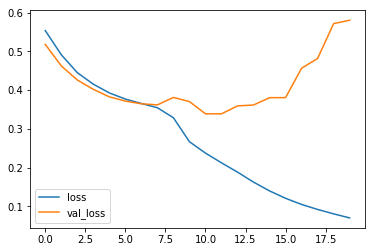

CPU times: user 2min 52s, sys: 46.8 s, total: 3min 39s
Wall time: 50.6 s


In [74]:
%%time 

np.random.seed(0)

model = build_nn(sender_size=128, chat_size=4, STEPS=32, lr=0.0001, fasttext_size=100)
X1, Y1, val1 = build_dataset(samples=5, steps=32, vectors=vectors100)
model.fit(X1, Y1, validation_data=val1, epochs=20, verbose=0)

plt.plot(model.history.history['loss'], label='loss')
plt.plot(model.history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

y_pred = model.predict(val1[0])
roc_auc_score(val1[1], y_pred)

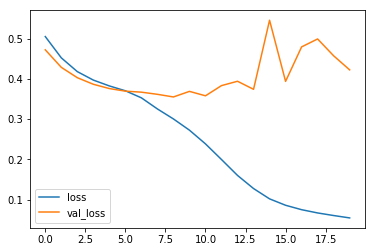

CPU times: user 2min 57s, sys: 48.1 s, total: 3min 45s
Wall time: 52.8 s


In [75]:
%%time 

np.random.seed(0)

model = build_nn(sender_size=128, chat_size=4, STEPS=32, lr=0.0001, fasttext_size=160)
X1, Y1, val1 = build_dataset(samples=5, steps=32, vectors=vectors160)
model.fit(X1, Y1, validation_data=val1, epochs=20, verbose=0)

plt.plot(model.history.history['loss'], label='loss')
plt.plot(model.history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

y_pred = model.predict(val1[0])
roc_auc_score(val1[1], y_pred)

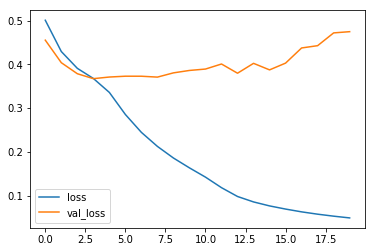

CPU times: user 3min 12s, sys: 49.1 s, total: 4min 1s
Wall time: 53.1 s


In [76]:
%%time 

np.random.seed(0)

model = build_nn(sender_size=128, chat_size=4, STEPS=32, lr=0.0001, fasttext_size=260)
X1, Y1, val1 = build_dataset(samples=5, steps=32, vectors=np.concatenate([vectors100, vectors160], axis=1))
model.fit(X1, Y1, validation_data=val1, epochs=20, verbose=0)

plt.plot(model.history.history['loss'], label='loss')
plt.plot(model.history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

y_pred = model.predict(val1[0])
roc_auc_score(val1[1], y_pred)

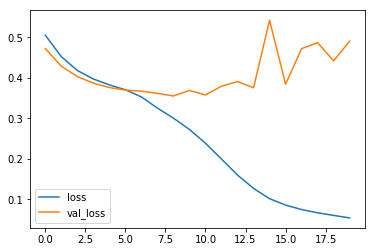

CPU times: user 3min 1s, sys: 46 s, total: 3min 47s
Wall time: 52 s


In [77]:
%%time 

np.random.seed(0)

model = build_nn(sender_size=128, chat_size=4, STEPS=32, lr=0.0001, fasttext_size=160)
X1, Y1, val1 = build_dataset(samples=5, steps=32, vectors=np.concatenate([vectors100, vectors60], axis=1))
model.fit(X1, Y1, validation_data=val1, epochs=20, verbose=0)

plt.plot(model.history.history['loss'], label='loss')
plt.plot(model.history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

y_pred = model.predict(val1[0])
roc_auc_score(val1[1], y_pred)

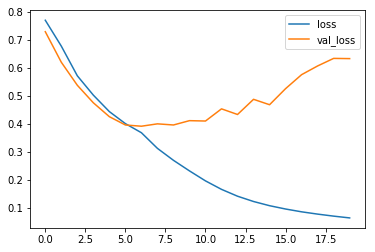

CPU times: user 2min 47s, sys: 46.3 s, total: 3min 34s
Wall time: 50.2 s


In [78]:
%%time 

np.random.seed(0)

model = build_nn(sender_size=128, chat_size=4, STEPS=32, lr=0.0001, fasttext_size=60)
X1, Y1, val1 = build_dataset(samples=5, steps=32, vectors=vectors60)
model.fit(X1, Y1, validation_data=val1, epochs=20, verbose=0)

plt.plot(model.history.history['loss'], label='loss')
plt.plot(model.history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

y_pred = model.predict(val1[0])
roc_auc_score(val1[1], y_pred)

In [82]:
with open('../data/train_test.pkl', 'wb') as f:
    f.write(pickle.dumps({
        'x': X1,
        'y': Y1,
        'validation': val1,
    }))

# tune hyperparams

In [29]:
space = {
    'sender_size': hp.choice('sender_size', list(range(8, 256))),
    'chat_size': hp.choice('chat_size', list(range(2, 10))),
    'steps': hp.choice('steps', [32, 64, 128]),
    'lr': 10**hp.uniform('lr', -8, -2),
    'samples': hp.choice('samples', list(range(1, 10))),
}

In [30]:
x = hyperopt.pyll.stochastic.sample(space)

In [31]:
x

{'chat_size': 2,
 'lr': 0.0016457644842810236,
 'samples': 1,
 'sender_size': 114,
 'steps': 128}

In [32]:
del x

In [53]:
def objective(x):
    
    np.random.seed(0)
    
    print(x)
    
    model = build_nn(
        sender_size=x['sender_size'], chat_size=x['chat_size'], STEPS=x['steps'], 
        lr=x['lr'], fasttext_size=100)
    X1, Y1, val1 = build_dataset(samples=x['samples'], steps=x['steps'], vectors=vectors100)
    model.fit(X1, Y1, validation_data=val1, epochs=20, verbose=0)
    
    y_pred = model.predict(val1[0])
    score = roc_auc_score(val1[1], y_pred)
    
    print('roc_auc', score)
    
    return {'loss': -score, 'status': STATUS_OK}

In [54]:
trials = Trials()

In [55]:
best = fmin(objective, space, algo=tpe.suggest, max_evals=20, trials=trials)

{'chat_size': 7, 'lr': 0.006918750043673687, 'samples': 8, 'sender_size': 198, 'steps': 128}
roc_auc 0.6615463389656937
{'chat_size': 5, 'lr': 9.995474354714894e-07, 'samples': 6, 'sender_size': 80, 'steps': 32}
roc_auc 0.5905797101449276
{'chat_size': 8, 'lr': 1.1455768949709289e-08, 'samples': 3, 'sender_size': 28, 'steps': 32}
roc_auc 0.49666436622958365
{'chat_size': 7, 'lr': 0.007455494149785534, 'samples': 5, 'sender_size': 78, 'steps': 128}
roc_auc 0.6386650386650388
{'chat_size': 2, 'lr': 3.632134753241807e-06, 'samples': 3, 'sender_size': 172, 'steps': 128}
roc_auc 0.49689440993788825
{'chat_size': 8, 'lr': 4.970548031870346e-06, 'samples': 4, 'sender_size': 217, 'steps': 32}
roc_auc 0.5555555555555556
{'chat_size': 3, 'lr': 1.892660765248683e-06, 'samples': 6, 'sender_size': 229, 'steps': 128}
roc_auc 0.4702093397745571
{'chat_size': 5, 'lr': 7.460944658023947e-05, 'samples': 6, 'sender_size': 189, 'steps': 64}
roc_auc 0.6499884978145848
{'chat_size': 4, 'lr': 3.0370119356449

In [56]:
best

{'chat_size': 3,
 'lr': -4.478658345494257,
 'samples': 4,
 'sender_size': 205,
 'steps': 2}

In [59]:
{'chat_size': 5, 'lr': 0.000033215565785761354, 'samples': 5, 'sender_size': 213, 'steps': 128}
# roc_auc 0.7789987789987789

{'chat_size': 5,
 'lr': 3.3215565785761354e-05,
 'samples': 5,
 'sender_size': 213,
 'steps': 128}

Train on 3186 samples, validate on 354 samples
Epoch 1/20
3186/3186 [==============================] - 10s 3ms/step - loss: 0.4798 - acc: 0.8836 - val_loss: 0.4677 - val_acc: 0.8898
Epoch 2/20
3186/3186 [==============================] - 6s 2ms/step - loss: 0.4640 - acc: 0.8836 - val_loss: 0.4525 - val_acc: 0.8898
Epoch 3/20
3186/3186 [==============================] - 6s 2ms/step - loss: 0.4483 - acc: 0.8836 - val_loss: 0.4384 - val_acc: 0.8898
Epoch 4/20
3186/3186 [==============================] - 6s 2ms/step - loss: 0.4343 - acc: 0.8836 - val_loss: 0.4265 - val_acc: 0.8898
Epoch 5/20
3186/3186 [==============================] - 6s 2ms/step - loss: 0.4226 - acc: 0.8836 - val_loss: 0.4166 - val_acc: 0.8898
Epoch 6/20
3186/3186 [==============================] - 6s 2ms/step - loss: 0.4125 - acc: 0.8836 - val_loss: 0.4079 - val_acc: 0.8898
Epoch 7/20
3186/3186 [==============================] - 6s 2ms/step - loss: 0.4038 - acc: 0.8836 - val_loss: 0.4004 - val_acc: 0.8898
Epoch 8/20
318

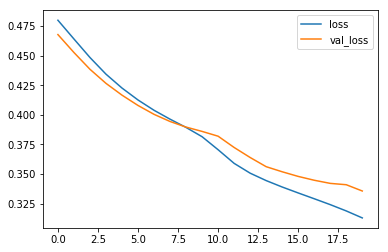

roc auc 0.7917785917785917
CPU times: user 10min 1s, sys: 1min 44s, total: 11min 46s
Wall time: 2min 22s


In [64]:
%%time 

np.random.seed(0)

model = build_nn(sender_size=213, chat_size=5, STEPS=128, lr=0.00003, fasttext_size=100)
X1, Y1, val1 = build_dataset(samples=5, steps=128, vectors=vectors100)
model.fit(X1, Y1, validation_data=val1, epochs=20)

plt.plot(model.history.history['loss'], label='loss')
plt.plot(model.history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

y_pred = model.predict(val1[0])
score = roc_auc_score(val1[1], y_pred)

print('roc auc', score)

[]

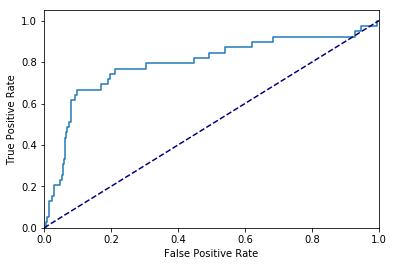

In [68]:
fpr, tpr, _ = roc_curve(val1[1], y_pred)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot()